# Reconstructing a B-mode ultrasound image

In [1]:
# General use
import numpy as np
import matplotlib.pyplot as plt
# For the scan conversion part
import math
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import decimate, convolve 

In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Setup 

### Description

A probe was set to capture continuously from an ATL3 probe (on the left hand of the setup image) which has a head containing 3 single element, focused transducers.

The head just spins continously. It allows the capture of a line after line:

![](https://raw.githubusercontent.com/kelu124/echomods/master/include/20161016/concept2.PNG)


### Overall

![](https://raw.githubusercontent.com/kelu124/echomods/master/elmo/images/20170717_210209.jpg)


### Phantom used

![](https://github.com/kelu124/echomods/blob/master/wirephantom/DSC_1181.JPG?raw=true)

# Loading data

### There are prepared datasets of the data.

If you want to get into the details, [it is detailed in here](https://github.com/kelu124/echomods/blob/a479ca0ee76d4f0e91d52c87de530f6b40d69607/elmo/data/20170715-ProbeTest.ipynb)

* This datasets contains 1000 lines.
* Sampling speed at around 10.67MHz

In [3]:
rf_env = np.load("data/probeX/tableDataH.npz")["tableDataH"]
rf_fil = np.load("data/probeX/tableDataFiltered.npz")["tableDataFiltered"]
rf_raw = np.load("data/probeX/tableDataRaw.npz")["tableDataRaw"]
t = np.load("data/probeX/t.npz")["t"]
np.shape(rf_env)

(1000, 5000)

### Let's see what we have:

* Raw contains the raw signal from ADC
* Fil contains the filtered data
* Env contains the enveloppe of the signal

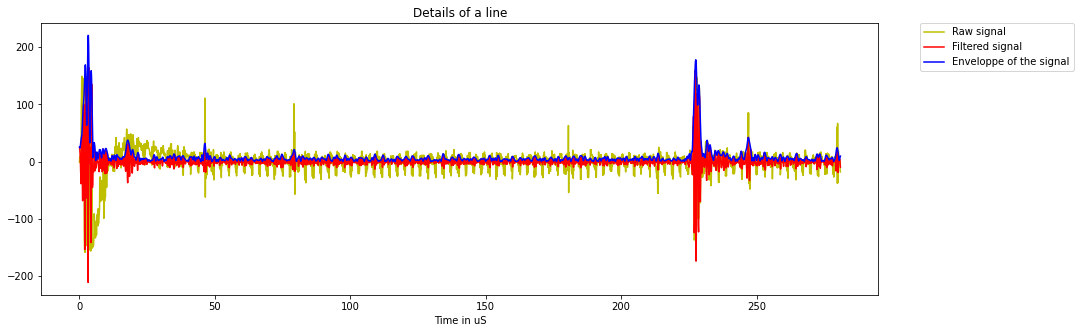

In [4]:
plt.figure(figsize=(15,5))
plt.plot(t[0:3000],rf_raw[110][0:3000],"y", label='Raw signal')
plt.plot(t[0:3000],rf_fil[110][0:3000],"r", label='Filtered signal')
plt.plot(t[0:3000],rf_env[110][0:3000],"b", label='Enveloppe of the signal')
plt.title("Details of a line")
plt.xlabel("Time in uS")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("data/probeX/outputs/example_of_a_line.jpg", bbox_inches='tight') 
plt.show()

#### We need to add an initial offset

(dark part on the left hand of the image below, 400 first pixels ~ 40us)

In [5]:
Val = np.average(rf_env) 
Offset = 400
MinTable = 10*np.min(rf_env)
Zeroes = np.zeros((1000,Offset))+Val
BigTable = []
BigTable = np.append(Zeroes, rf_env, axis=1)

### Let's see now what we have. 

Plotting the absolute value of our table to see what it looks like.

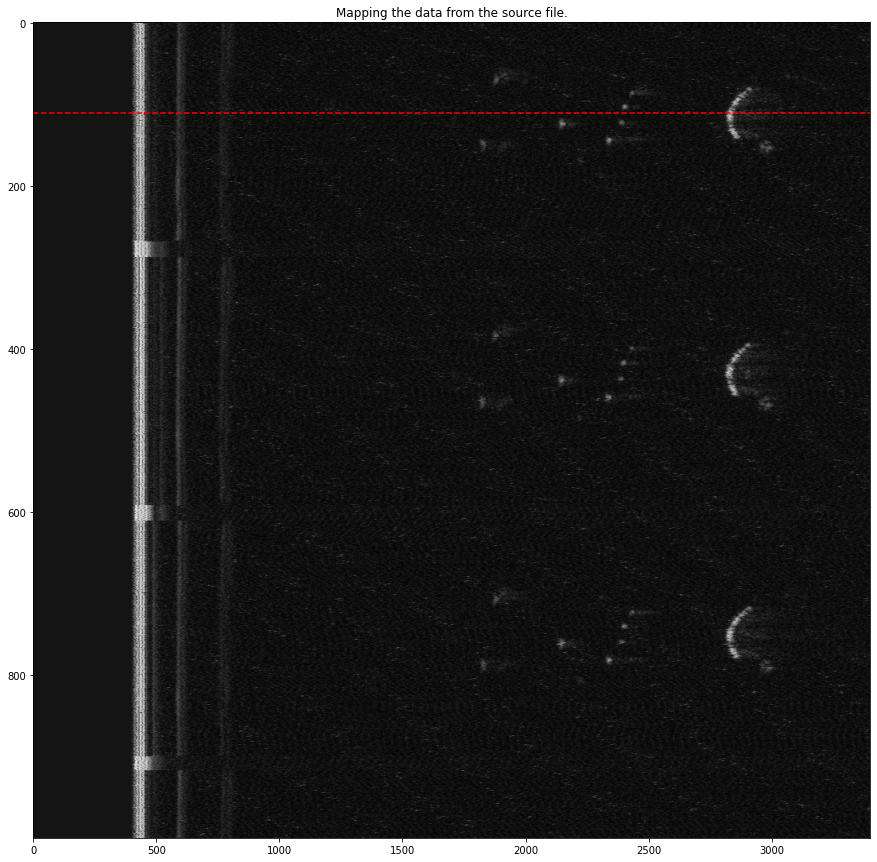

In [6]:
IndexLine = 110
plt.figure(figsize=(15,15))
tableData = BigTable[:,:3000+Offset]
plt.imshow((abs(tableData)**0.7), aspect='auto',cmap=plt.get_cmap('gray'))
plt.axhline(IndexLine, color='r', linestyle='--')
plt.title("Mapping the data from the source file.")   
plt.savefig("data/probeX/outputs/dataset_content.jpg", bbox_inches='tight') 
plt.show()

### Let's split our continous acquisiton in 3 frames

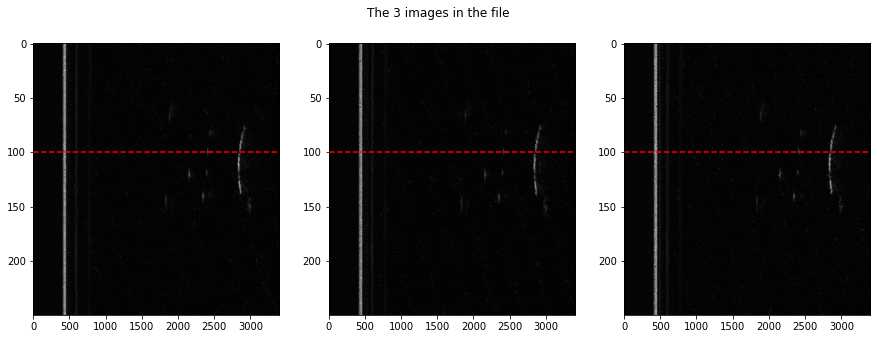

In [7]:
ListOfPoints= [104, 418, 741]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

TmpImg = (abs(tableData[ListOfPoints[0]-100:ListOfPoints[0]+150]))**(1.1)
ax1.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax1.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[1]-100:ListOfPoints[1]+150]))**(1.1)
ax2.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax2.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[2]-100:ListOfPoints[2]+150]))**(1.1)
ax3.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax3.axhline(100, color='r', linestyle='--')
plt.suptitle('The 3 images in the file')
plt.savefig("data/probeX/outputs/images_contained.jpg", bbox_inches='tight') 
plt.show()

## Let us decimate the image to have fewer points to process

We'll be going to 3400 pts to 680

In [8]:
DecImg = []
for i in range(150):
    tmp = decimate(tableData[ListOfPoints[0]-70+i], 5, ftype='fir')
    tmp += decimate(tableData[ListOfPoints[1]-70+i], 5, ftype='fir')
    tmp += decimate(tableData[ListOfPoints[2]-70+i], 5, ftype='fir')
    DecImg.append(tmp) 
SmallImg = []
for i in range(int(len(DecImg)/2)):
    SmallImg.append((DecImg[2*i]+DecImg[2*i+1])/2)

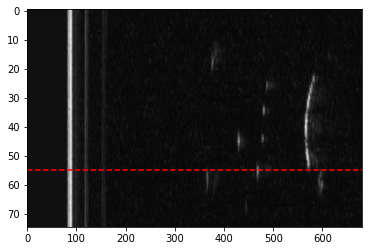

In [9]:
plt.axhline(IndexLine/2, color='r', linestyle='--')
# The **0.7 is used to flatten the image, easier on the human eyes
plt.imshow(np.asarray(SmallImg)**(0.7),cmap=plt.get_cmap('gray'), aspect='auto') 
plt.show() 

## Defining a scan conversion algorithm

#### Function below

In [10]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    SC = np.zeros((LenLinesC,LenLinesC))+Val
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC

## Applying this to our image

In [11]:
SCH,valuesH,pointsH,LenLinesCH = CreateSC(SmallImg)
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')

/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


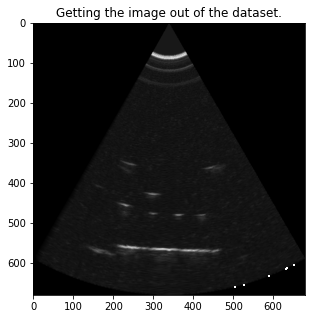

In [12]:
plt.figure(figsize=(15,5))
plt.imshow((grid_z1H**0.7),cmap=plt.get_cmap('gray')) 
plt.title("Getting the image out of the dataset.")   
plt.savefig("data/probeX/outputs/scan_converted.jpg", bbox_inches='tight') 
plt.show()

# Summary

/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


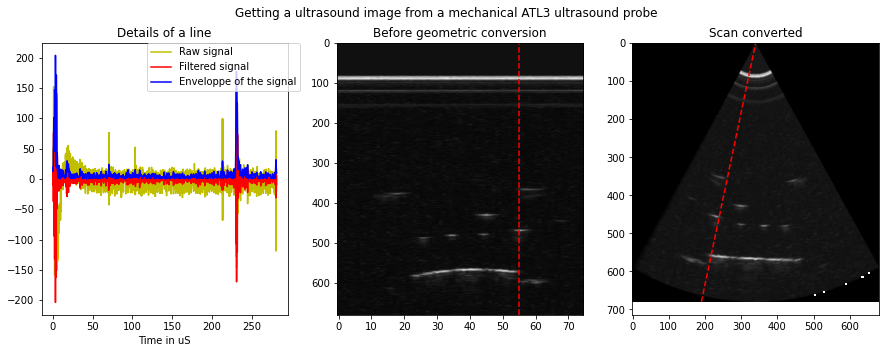

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

TmpImg = (abs(tableData[ListOfPoints[0]-100:ListOfPoints[0]+150]))**(1.1)
ax1.plot(t[0:3000],rf_raw[94][0:3000],"y", label='Raw signal')
ax1.plot(t[0:3000],rf_fil[94][0:3000],"r", label='Filtered signal')
ax1.plot(t[0:3000],rf_env[94][0:3000],"b", label='Enveloppe of the signal')
ax1.set_title("Details of a line")
ax1.set_xlabel("Time in uS")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


ax2.axvline(110/2, color='r', linestyle='--')
ax2.imshow(np.transpose(np.asarray(SmallImg))**(0.7),cmap=plt.get_cmap('gray'), aspect='auto')
ax2.set_title("Before geometric conversion")

ax3.imshow((grid_z1H**0.7),cmap=plt.get_cmap('gray'), aspect='auto') 
x1, y1 = [190, 680/2], [680, 0]
plt.plot(x1, y1, color='r', linestyle='--')
ax3.set_title("Scan converted")
    

plt.suptitle('Getting a ultrasound image from a mechanical ATL3 ultrasound probe')
plt.savefig("data/probeX/outputs/processing_path.jpg", bbox_inches='tight') 
plt.show()